# Домашнее задание №3

In [1]:
import xml.etree.ElementTree as ET
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

## Метод и результаты разметки

Разметка осуществлялась в CVAT двумя разметчиками. Задача была разметить главные фотографии объявлений аренды квартир на несколько классов по признаку ремонта: без ремонта, невозможно определить, косметический ремонт, евроремонт, дизайнерский ремонт.

Посмотрим на результаты разметки. Выведем коэффициент согласованности и абсолютное число несовпадений:

In [2]:
def parse_image_labels(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    labels = {}

    for image in root.findall('.//image'):
        image_id = image.get('id')
        label = image.find('.//tag').get('label')
        labels[image_id] = label
    
    return labels

def count_disagreements(labels1, labels2):
    disagreements = sum(1 for image_id in labels1 if labels1.get(image_id) != labels2.get(image_id))
    return disagreements

def calculate_cohen_kappa(labels1, labels2):
    common_ids = sorted(set(labels1.keys()).intersection(labels2.keys()))
    labels_list1 = [labels1[image_id] for image_id in common_ids]
    labels_list2 = [labels2[image_id] for image_id in common_ids]
    
    return cohen_kappa_score(labels_list1, labels_list2)

file1 = 'C:/Users/popov/markedup/annotations1.xml'
file2 = 'C:/Users/popov/markedup/annotations2.xml'

labels_file1 = parse_image_labels(file1)
labels_file2 = parse_image_labels(file2)

# Подсчет несовпадений
disagreements = count_disagreements(labels_file1, labels_file2)
print(f'Количество несовпадений: {disagreements}')

# Коэффициент Каппа Коэна
kappa_score = calculate_cohen_kappa(labels_file1, labels_file2)
print(f'Коэффициент Каппа Коэна: {kappa_score:.2f}')

Количество несовпадений: 305
Коэффициент Каппа Коэна: 0.47


Полученный коэффициент Каппа Коэна указывает на умеренную согласованность меток. В абсолютном эквиваленте несогласованность составила 305 меток из 1000.

В таких случаях для слияния меток используется метка большинства, однако в нашем случае разметчиков было всего 2, поэтому для вычленения консенсуса я принял решение выбрать в спорных случаях метки, с которыми больше согласен, в соответствии с ТЗ.

Посмотрим на результат. Реализуем функцию поиска пропусков и дубликатов:

In [3]:
def check_for_missing_and_duplicates(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    image_ids = set()
    duplicates = set()

    for image in root.findall('.//image'):
        image_id = image.get('id')
        if image_id in image_ids:
            duplicates.add(image_id)
        else:
            image_ids.add(image_id)

        tags = image.findall('.//tag')
        if len(tags) != 1:
            print(f'ID {image_id} имеет не одну метку.')
    
    if duplicates:
        print(f'ID дубликатов: {duplicates}')
    else:
        print('Нет дубликатов.')
    
    all_labels = [image.find('.//tag').get('label') for image in root.findall('.//image') if image.find('.//tag') is not None]
    if len(all_labels) < len(image_ids):
        print('Есть пропуски.')
    else:
        print('Нет пропусков.')



file_path = 'C:/Users/popov/markedup/consensus.xml'


In [4]:

check_for_missing_and_duplicates(file_path)

Нет дубликатов.
Нет пропусков.


Это отличный результат - пропусков и дубликатов нет, а также каждое фото имеет по 1 метке.

Построим график распределения меток классов:

In [5]:
def visualize_label_distribution(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    labels = [image.find('.//tag').get('label') for image in root.findall('.//image') if image.find('.//tag') is not None]

    label_counts = Counter(labels)

    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

    labels, counts = zip(*sorted_labels)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Метка')
    plt.ylabel('Количество')
    plt.title('Распределение меток')
    plt.xticks(rotation=45)
    plt.tight_layout()

    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(count), va='bottom', ha='center')

    plt.show()

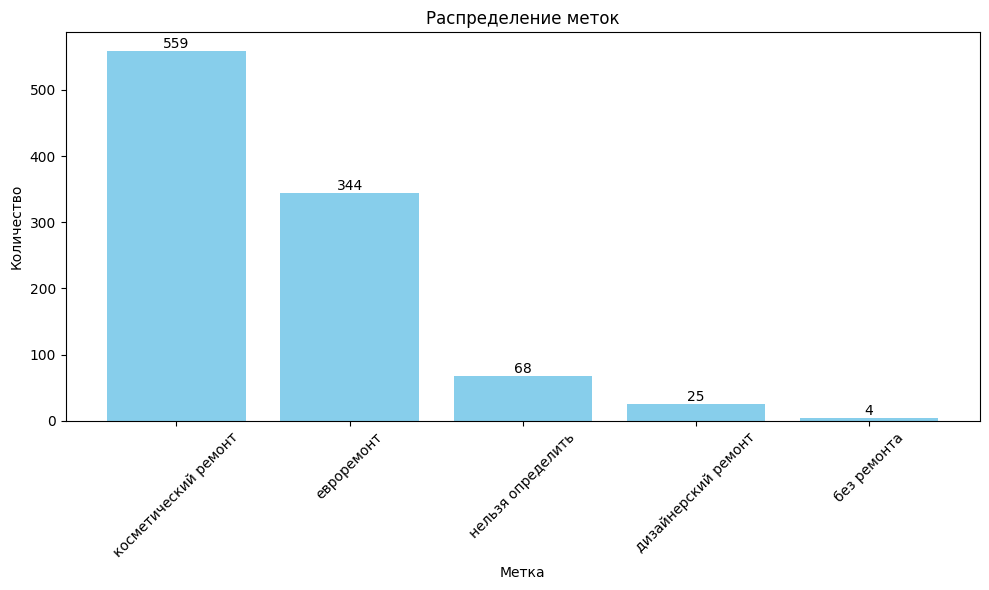

In [6]:
visualize_label_distribution(file_path)

На графике видно, что большинство квартир имеют косметический ремонт (559) и евроремонт (344), что говорит о популярности и доступности этих вариантов. Категории "нельзя определить" (68) и "дизайнерский ремонт" (25) встречаются реже, а без ремонта всего 4 квартиры.

## Сохранение разметки

Загрузим датасет из предыдущего задания:

In [7]:
df = pd.read_csv('C:/Users/popov/mirkvartir_cleaned.csv', sep=';')

Извлечем финальные метки:

In [8]:
def extract_labels_from_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    image_labels = {}

    for image in root.findall('.//image'):
        image_name = image.get('name')
        tag = image.find('.//tag')
        if tag is not None:
            label = tag.get('label')
            image_labels[image_name] = label

    return image_labels

labels = extract_labels_from_xml('C:/Users/popov/markedup/consensus.xml')

Извлечем из url имена фото:

In [9]:

def extract_image_name(url):
    return url.split('/')[-1] if isinstance(url, str) else None

In [10]:
df['main_photo_name'] = df['main_photo_url'].apply(extract_image_name)

df['main_photo_label'] = df['main_photo_name'].map(labels)

Проверим, сколько меток добавилось в датасет:

In [11]:
len(df) - df['main_photo_label'].isna().sum()

np.int64(1001)

Каким-то образом появилась одна лишняя метка:

In [12]:
df.groupby('main_photo_label')['id'].nunique()

main_photo_label
без ремонта               4
дизайнерский ремонт      25
евроремонт              345
косметический ремонт    559
нельзя определить        68
Name: id, dtype: int64

Итак, мы нашли неявный дубликат:

In [13]:
df[df['main_photo_name'] == '12dd9654-92c1-40cb-8273-722707235eb3.jpg']

,id,url,title,description,price,latitude,longitude,metro_name,address,agency_name,...,floor,total_floors,price_per_sqm,dist_to_metro,dist_to_park,dist_to_water,dist_to_airport,nearest_metro,main_photo_name,main_photo_label
256,341023568,https://arenda.mirkvartir.ru/341023568/,"2-комн., 60 м², 10/12 этаж",Сдается в длительную аренду двушка площадью 60...,95000,59.89739,30.330402,Московские ворота,"Санкт-Петербург, Черниговская ул., 17",Домклик,...,10.0,12.0,1583.333333,866.529987,455.656379,1326.608688,11466.893072,Московские ворота,12dd9654-92c1-40cb-8273-722707235eb3.jpg,евроремонт
2105,340631193,https://arenda.mirkvartir.ru/340631193/,"2-комн., 58 м², 10/12 этаж",Сдается в аренду 2-комнатная квартира площадью...,110000,59.89739,30.330402,Московские ворота,"Санкт-Петербург, Черниговская ул., 17",Домклик,...,10.0,12.0,1896.551724,866.529987,455.656379,1326.608688,11466.893072,Московские ворота,12dd9654-92c1-40cb-8273-722707235eb3.jpg,евроремонт


Судя по данным, одна и та же квартира представлена в агрегаторе в двух объявлениях, такое иногда случается, когда агент хочет посмотреть отклики по разным ценам или просто увеличить шансы. Разнятся площади и описания, поэтому пока оставим, как есть.

Сохраним результаты разметки для следующего задания в новый датасет:

In [14]:
# df.to_csv('C:/Users/popov/mirkvartir_with_labels.csv', sep=';', index=False)

## Приложения

- [**ТЗ**](https://www.notion.so/1926273c27bb80dd9f85fd7cda125eb3?pvs=4)
- [**Инструкция по работе с системой CVAT**](https://www.notion.so/1926273c27bb80dd9f85fd7cda125eb3?pvs=4)
- Моя рефлексия и ОС от разметчиков - в README, в разделе ДЗ 3

## Definition of Done

- Возьмите открытый табличный датасет, набор текстовых данных (например, отзывы о продукте) или набор изображений (можно взять из открытых источников).
    - ✅ Есть опция, что можете взять, то что было в первом дз
- ✅ Напишите ТЗ (в свободной форме) для разметки выбранного датасета. (Для текстового датасета можно предложить разметку семантики, для набора изображений – детекцию или сегментацию). Не забывайте про примеры в ТЗ!
- ✅ Добавьте какой-либо валидатор (принимаются подмешивание тестовых кейсов/расчёт метрики согласованности – в этом случае нужно будет предоставить разметку от минимум 2х людей).
- ✅ Отправьте ваш собранный (но неразмеченный!) датасет знакомому с курса и предложите разметить по вашему ТЗ. **Получите обратную связь.** Для разметки допустимо использовать одну из онлайн-платформ или самостоятельные инструменты (предоставьте инструмент вашему разметчику).
- ✅ Проанализируйте полученные результаты разметки на наличие выбросов/дубликатов/некорректных результатов. Примените методы для их коррекции или удаления. Оцените метрику согласованности, либо квалификацию вашего разметчика на подмешанных тестовых кейсах.
- ✅ Порефлексируйте на тему процесса разметки данных и качества полученных результатов.